In [143]:
import keras
import pandas as pd
import numpy as np
from keras.layers import *
from keras.activations import *
from keras.callbacks import *
from keras.optimizers import *
from keras.models import *
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
import stldecompose

In [144]:
data_orig = pd.read_csv('../data/files/multiple_concatenated_tickers.csv')
data_orig.tail()

,Index,A.Open,A.High,A.Low,A.Close,A.Volume,A.Adjusted,AAL.Open,AAL.High,AAL.Low,...,XLRE.Low,XLRE.Close,XLRE.Volume,XLRE.Adjusted,ROKU.Open,ROKU.High,ROKU.Low,ROKU.Close,ROKU.Volume,ROKU.Adjusted
849,2019-05-20,68.660004,69.970001,68.639999,68.930000,4029700.0,68.930000,30.650000,31.219999,30.219999,...,35.919998,36.049999,3472100,36.049999,83.809998,85.000000,81.230003,83.330002,11115100,83.330002
850,2019-05-21,69.370003,70.440002,68.250000,68.320000,3928200.0,68.320000,31.209999,31.639999,31.129999,...,36.150002,36.349998,2353600,36.349998,83.970001,87.650002,83.750000,87.629997,10989400,87.629997
851,2019-05-22,68.169998,68.639999,67.510002,67.970001,4985400.0,67.970001,31.230000,31.230000,29.809999,...,36.310001,36.520000,1982800,36.520000,87.790001,89.349998,86.470001,88.019997,10019400,88.019997
852,2019-05-23,67.180000,67.849998,66.029999,67.699997,5358500.0,67.699997,29.730000,29.980000,29.309999,...,36.360001,36.700001,2521100,36.700001,87.790001,90.000000,86.620003,89.980003,11658800,89.980003
853,2019-05-24,68.139999,69.889999,68.080002,68.360001,3852900.0,68.360001,29.690001,29.940001,28.980000,...,36.740002,36.750000,1523600,36.750000,90.500000,95.949997,90.080002,95.779999,19017200,95.779999


In [145]:
vol_data_orig = pd.read_csv('../data/files/multiple_concatenated_tickers_volatility.csv')
vol_data20_orig = pd.read_csv('../data/files/multiple_concatenated_tickers_volatility20.csv')
#vol_data50_orig = pd.read_csv('../data/files/multiple_concatenated_tickers_volatility50.csv')
#vol_data100_orig = pd.read_csv('../data/files/multiple_concatenated_tickers_volatility100.csv')
vol_data_orig.tail()

,Index,volatilityA,volatilityAAL,volatilityAAP,volatilityAAPL,volatilityABBV,volatilityABC,volatilityABMD,volatilityABT,volatilityACN,...,volatilityXLI,volatilityXLY,volatilityXLP,volatilityXLV,volatilityXLF,volatilityXLK,volatilityXTL,volatilityXLU,volatilityXLRE,volatilityROKU
849,2019-05-20,0.714049,0.328068,0.158187,0.373833,0.135074,0.257892,0.268996,0.111844,0.169008,...,0.191919,0.199266,0.110759,0.122998,0.189780,0.269788,0.222987,0.151159,0.124564,1.369034
850,2019-05-21,0.711299,0.346673,0.168127,0.405106,0.145401,0.259004,0.324879,0.105041,0.168105,...,0.205990,0.205222,0.112259,0.133840,0.201185,0.283061,0.242188,0.117787,0.129286,1.367147
851,2019-05-22,0.705082,0.384676,0.227639,0.409748,0.143802,0.267510,0.340572,0.105421,0.168182,...,0.209850,0.210322,0.111044,0.136005,0.203063,0.282333,0.230469,0.115043,0.129796,0.434184
852,2019-05-23,0.701958,0.373635,0.323200,0.409422,0.142538,0.252826,0.339550,0.113759,0.187090,...,0.218731,0.215441,0.093721,0.138184,0.208100,0.292086,0.247085,0.088779,0.119618,0.435557
853,2019-05-24,0.688995,0.283648,0.312301,0.279113,0.162228,0.191779,0.324037,0.130737,0.135046,...,0.157418,0.145425,0.076635,0.071508,0.142033,0.206949,0.190810,0.081608,0.119175,0.402319


In [146]:
data_orig = data_orig\
  .merge(vol_data_orig, how="inner", left_on=data_orig.Index, right_on=vol_data_orig.Index).fillna(method="ffill")\
  .drop(["key_0", "Index_y"], axis=1)\
  .merge(vol_data20_orig, how="inner", left_on=data_orig.Index, right_on=vol_data_orig.Index).fillna(method="ffill")\
  .drop(["key_0", "Index_x"], axis=1)

In [147]:
[i for i in list(data_orig.columns) if i == 'Index']

['Index']

In [148]:
from urllib.request import *
from io import StringIO
import pandas as pd

def df_from_fred(setname):
    # Make GET Request
    response = urlopen(url_for(setname))
    # Read response data
    data = response.read()
    # Convert binary text to utf-8
    text = data.decode('utf-8')
    # Convert text file to pandas dataframe
    TEXTDATA = StringIO(text)
    df = pd.read_csv(TEXTDATA, sep=",")
    return df

def url_for(series):
    """function takes FRED series name as input. For example, GDPC1, or HOUST."""
    return "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=968&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id="+series+"&scale=left&cosd=1947-01-01&coed=2019-01-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Quarterly&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2019-05-07&revision_date=2019-05-07&nd=1947-01-01"


In [149]:
# Vital Economic indicators: https://gist.github.com/ngopal/262fce10a7fa4a8467f0c61a13c85dc5
GDPC1 = df_from_fred("GDPC1")
time.sleep(5)
M2 = df_from_fred("M2")
time.sleep(5)
CPALTT01USQ657N = df_from_fred("CPALTT01USQ657N")
time.sleep(5)
PPIACO = df_from_fred("PPIACO")
time.sleep(5)
UMCSENT = df_from_fred("UMCSENT")
time.sleep(5)
PAYEMS = df_from_fred("PAYEMS")
time.sleep(5)
RRSFS = df_from_fred("RRSFS")
time.sleep(5)
HOUST = df_from_fred("HOUST")
time.sleep(5)
ISRATIO = df_from_fred("ISRATIO")
time.sleep(5)
SP500 = df_from_fred("SP500")
time.sleep(5)

# Thoughts
FEDFUNDS = df_from_fred("FEDFUNDS")
time.sleep(5)
UNRATE = df_from_fred("UNRATE")
time.sleep(5)
T10Y2Y = df_from_fred("T10Y2Y")
time.sleep(5)
CBBTCUSD = df_from_fred("CBBTCUSD")
time.sleep(5)
USSLIND = df_from_fred("USSLIND")
time.sleep(5)

# Others
IPMAN = df_from_fred("IPMAN")
time.sleep(5)
MPU9900063 = df_from_fred("MPU9900063")
time.sleep(5)
PCU33443344 = df_from_fred("PCU33443344")
time.sleep(5)
MEHOINUSA672N = df_from_fred("MEHOINUSA672N")
time.sleep(5)
TCMDO = df_from_fred("TCMDO")
time.sleep(5)
FGTCMDODNS = df_from_fred("FGTCMDODNS")
time.sleep(5)
ADSLFAA027N = df_from_fred("ADSLFAA027N")
time.sleep(5)
NCBCMDPMVCE = df_from_fred("NCBCMDPMVCE")
time.sleep(5)
FGCCSAQ027S = df_from_fred("FGCCSAQ027S")
time.sleep(5)
ASTNITA = df_from_fred("ASTNITA")
time.sleep(5)
PCETRIM12M159SFRBDAL = df_from_fred("PCETRIM12M159SFRBDAL")

# IPMAN, MPU9900063, PCU33443344, MEHOINUSA672N, TCMDO, FGTCMDODNS, ADSLFAA027N, NCBCMDPMVCE, FGCCSAQ027S, ASTNITA

In [150]:
data_orig = data_orig\
  .merge(GDPC1, how="left", left_on=data_orig.Index, right_on=GDPC1.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(M2, how="left", left_on=data_orig.Index, right_on=M2.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(CPALTT01USQ657N, how="left", left_on=data_orig.Index, right_on=CPALTT01USQ657N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PPIACO, how="left", left_on=data_orig.Index, right_on=PPIACO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(UMCSENT, how="left", left_on=data_orig.Index, right_on=UMCSENT.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PAYEMS, how="left", left_on=data_orig.Index, right_on=PAYEMS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(RRSFS, how="left", left_on=data_orig.Index, right_on=RRSFS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(HOUST, how="left", left_on=data_orig.Index, right_on=HOUST.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ISRATIO, how="left", left_on=data_orig.Index, right_on=ISRATIO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PCETRIM12M159SFRBDAL, how="left", left_on=data_orig.Index, right_on=PCETRIM12M159SFRBDAL.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ASTNITA, how="left", left_on=data_orig.Index, right_on=ASTNITA.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FGCCSAQ027S, how="left", left_on=data_orig.Index, right_on=FGCCSAQ027S.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(NCBCMDPMVCE, how="left", left_on=data_orig.Index, right_on=NCBCMDPMVCE.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ADSLFAA027N, how="left", left_on=data_orig.Index, right_on=ADSLFAA027N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FGTCMDODNS, how="left", left_on=data_orig.Index, right_on=FGTCMDODNS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(TCMDO, how="left", left_on=data_orig.Index, right_on=TCMDO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(MEHOINUSA672N, how="left", left_on=data_orig.Index, right_on=MEHOINUSA672N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PCU33443344, how="left", left_on=data_orig.Index, right_on=PCU33443344.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(MPU9900063, how="left", left_on=data_orig.Index, right_on=MPU9900063.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(IPMAN, how="left", left_on=data_orig.Index, right_on=IPMAN.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(SP500, how="left", left_on=data_orig.Index, right_on=SP500.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FEDFUNDS, how="left", left_on=data_orig.Index, right_on=FEDFUNDS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(UNRATE, how="left", left_on=data_orig.Index, right_on=UNRATE.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(T10Y2Y, how="left", left_on=data_orig.Index, right_on=T10Y2Y.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(CBBTCUSD, how="left", left_on=data_orig.Index, right_on=CBBTCUSD.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(USSLIND, how="left", left_on=data_orig.Index, right_on=USSLIND.DATE).fillna(method="ffill")\
  .fillna(-1)

In [151]:
data_orig.drop(['DATE_y', 'DATE_x', 'key_0'], axis=1, inplace=True)

In [152]:
import pickle
import os
from keras.preprocessing import *
from nltk.stem import SnowballStemmer
from dateutil.parser import parse
from datetime import datetime

data = []
for i in os.listdir("../briefings/"):
    #print(i)
    f = open("../briefings/"+str(i), "rb")
    d = pickle.loads(f.read())
    data.append(d)

#Headlines
headlines = []
text_bodies = []
all_text = []
dates = []
snow = SnowballStemmer('english')
for i,v in enumerate(data):
    for k in v:
        #print(k["date"], k["headline"])
        if k["date"] == -1:
            continue
        w = parse(k["date"])
        headlines.append(''.join([snow.stem(w) for w in str(k["headline"])]))
        text_bodies.append(''.join([snow.stem(w) for w in str(k["text"])]))
        all_text.append(''.join([snow.stem(w) for w in str(k["headline"])]))
        dates.append(w.date().isoformat())
        all_text.append(''.join([snow.stem(w) for w in str(k["text"])]))
        dates.append(w.date().isoformat())

tokenizer = text.Tokenizer(num_words=500, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None)

In [161]:
tokenizer.fit_on_texts(all_text)
encoded_docs = tokenizer.texts_to_matrix(all_text, mode='tfidf')
tfidf_df = pd.DataFrame(encoded_docs)
tfidf_df["DATE"] = dates
tfidf_docs = tfidf_df.groupby(['DATE'], as_index=True).mean()

In [187]:
data_orig.set_index("Index", inplace=True)
data_orig = data_orig.merge(tfidf_docs, how="left", left_on=data_orig.index, right_on=tfidf_docs.index).fillna(method="ffill").rename(columns={'key_0': 'Index'}).set_index("Index")

In [188]:
list(data_orig.columns)

['A.Open',
 'A.High',
 'A.Low',
 'A.Close',
 'A.Volume',
 'A.Adjusted',
 'AAL.Open',
 'AAL.High',
 'AAL.Low',
 'AAL.Close',
 'AAL.Volume',
 'AAL.Adjusted',
 'AAP.Open',
 'AAP.High',
 'AAP.Low',
 'AAP.Close',
 'AAP.Volume',
 'AAP.Adjusted',
 'AAPL.Open',
 'AAPL.High',
 'AAPL.Low',
 'AAPL.Close',
 'AAPL.Volume',
 'AAPL.Adjusted',
 'ABBV.Open',
 'ABBV.High',
 'ABBV.Low',
 'ABBV.Close',
 'ABBV.Volume',
 'ABBV.Adjusted',
 'ABC.Open',
 'ABC.High',
 'ABC.Low',
 'ABC.Close',
 'ABC.Volume',
 'ABC.Adjusted',
 'ABMD.Open',
 'ABMD.High',
 'ABMD.Low',
 'ABMD.Close',
 'ABMD.Volume',
 'ABMD.Adjusted',
 'ABT.Open',
 'ABT.High',
 'ABT.Low',
 'ABT.Close',
 'ABT.Volume',
 'ABT.Adjusted',
 'ACN.Open',
 'ACN.High',
 'ACN.Low',
 'ACN.Close',
 'ACN.Volume',
 'ACN.Adjusted',
 'ADBE.Open',
 'ADBE.High',
 'ADBE.Low',
 'ADBE.Close',
 'ADBE.Volume',
 'ADBE.Adjusted',
 'ADI.Open',
 'ADI.High',
 'ADI.Low',
 'ADI.Close',
 'ADI.Volume',
 'ADI.Adjusted',
 'ADM.Open',
 'ADM.High',
 'ADM.Low',
 'ADM.Close',
 'ADM.Volume

In [190]:
ticker_lookup = dict([(i[1].split('.')[0], int(i[0])) for i in enumerate(list(data_orig.columns)) if (('Open' in str(i[1])) or ("volatility" in str(i[1]) ))])
ticker_lookup

{'A': 0,
 'AAL': 6,
 'AAP': 12,
 'AAPL': 18,
 'ABBV': 24,
 'ABC': 30,
 'ABMD': 36,
 'ABT': 42,
 'ACN': 48,
 'ADBE': 54,
 'ADI': 60,
 'ADM': 66,
 'ADP': 72,
 'ADS': 78,
 'ADSK': 84,
 'AEE': 90,
 'AEP': 96,
 'AES': 102,
 'AFL': 108,
 'AGN': 114,
 'AIG': 120,
 'AIV': 126,
 'AIZ': 132,
 'AJG': 138,
 'AKAM': 144,
 'ALB': 150,
 'ALGN': 156,
 'ALK': 162,
 'ALL': 168,
 'ALLE': 174,
 'ALXN': 180,
 'AMAT': 186,
 'AMD': 192,
 'AME': 198,
 'AMG': 204,
 'AMGN': 210,
 'AMP': 216,
 'AMT': 222,
 'AMZN': 228,
 'ANET': 234,
 'ANSS': 240,
 'ANTM': 246,
 'AON': 252,
 'AOS': 258,
 'APA': 264,
 'APC': 270,
 'APD': 276,
 'APH': 282,
 'APTV': 288,
 'ARE': 294,
 'ARNC': 300,
 'ATO': 306,
 'ATVI': 312,
 'AVB': 318,
 'AVGO': 324,
 'AVY': 330,
 'AWK': 336,
 'AXP': 342,
 'AZO': 348,
 'BA': 354,
 'BAC': 360,
 'BAX': 366,
 'BBT': 372,
 'BBY': 378,
 'BDX': 384,
 'BEN': 390,
 'BF': 396,
 'BHGE': 402,
 'BIIB': 408,
 'BK': 414,
 'BKNG': 420,
 'BLK': 426,
 'BLL': 432,
 'BMY': 438,
 'BR': 444,
 'BRK': 450,
 'BSX': 456,
 '

In [191]:
days_lookback = 1
pct_df = data_orig.iloc[:,0:].shift(days_lookback).fillna(-1)
pct_df

,A.Open,A.High,A.Low,A.Close,A.Volume,A.Adjusted,AAL.Open,AAL.High,AAL.Low,AAL.Close,...,90,91,92,93,94,95,96,97,98,99
Index,,,,,,,,,,,,,,,,,,,,,
2016-01-04,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2016-01-05,41.060001,41.189999,40.340000,40.689999,3287300.0,39.442612,41.290001,41.349998,40.299999,40.910000,...,0.840878,0.371414,0.345120,0.852809,0.512485,0.536899,0.000000,0.105707,0.588679,0.515919
2016-01-06,40.730000,40.950001,40.340000,40.549999,2587200.0,39.306896,41.180000,41.490002,39.950001,40.520000,...,0.842024,0.486375,0.275518,0.539413,0.848591,0.409066,0.000000,0.387246,0.499012,0.354835
2016-01-07,40.240002,40.990002,40.049999,40.730000,2103600.0,39.481392,40.049999,41.700001,40.000000,41.230000,...,1.014483,0.472807,0.459019,0.614182,0.717144,0.511332,0.000000,0.135564,0.642735,0.405525
2016-01-08,40.139999,40.150002,38.810001,39.000000,3504300.0,37.804417,40.970001,41.520000,39.680000,40.450001,...,1.029516,0.353727,0.420702,0.579585,0.688126,0.597909,0.201944,0.000000,0.570380,0.648423
2016-01-11,39.220001,39.709999,38.470001,38.590000,3736700.0,37.406982,40.939999,41.360001,40.259998,40.369999,...,0.591118,0.503455,0.275518,0.392243,0.653359,0.357933,0.000000,0.271127,0.705703,0.491352
2016-01-12,38.709999,38.900002,37.410000,37.939999,2818400.0,36.776905,40.560001,41.200001,39.900002,41.080002,...,0.624197,0.517023,0.372308,0.493173,0.444086,0.613599,0.000000,0.286573,0.380253,0.440661
2016-01-13,38.430000,38.580002,37.650002,38.189999,1989400.0,37.019245,41.150002,42.360001,40.480000,42.000000,...,0.624197,0.397943,0.700065,0.372749,0.668336,0.613599,0.000000,0.286573,0.550493,0.526488
2016-01-14,38.349998,38.470001,36.720001,36.860001,4206600.0,35.730026,42.169998,42.740002,39.660000,40.099998,...,0.319421,0.649671,0.570659,0.513634,0.897400,0.562466,0.000000,0.271127,0.483215,0.526488


In [194]:
data_orig.drop("DATE", axis=1, inplace=True)
pct_df.drop("DATE", axis=1, inplace=True)
# data_orig.drop("Index", axis=1, inplace=True)
# pct_df.drop("Index", axis=1, inplace=True)

KeyError: "['Index'] not found in axis"

In [195]:
inv_map = {v+'.Open': k for k, v in dict(enumerate(list(ticker_lookup.keys()))).items()}
inv_map

{'A.Open': 0,
 'AAL.Open': 1,
 'AAP.Open': 2,
 'AAPL.Open': 3,
 'ABBV.Open': 4,
 'ABC.Open': 5,
 'ABMD.Open': 6,
 'ABT.Open': 7,
 'ACN.Open': 8,
 'ADBE.Open': 9,
 'ADI.Open': 10,
 'ADM.Open': 11,
 'ADP.Open': 12,
 'ADS.Open': 13,
 'ADSK.Open': 14,
 'AEE.Open': 15,
 'AEP.Open': 16,
 'AES.Open': 17,
 'AFL.Open': 18,
 'AGN.Open': 19,
 'AIG.Open': 20,
 'AIV.Open': 21,
 'AIZ.Open': 22,
 'AJG.Open': 23,
 'AKAM.Open': 24,
 'ALB.Open': 25,
 'ALGN.Open': 26,
 'ALK.Open': 27,
 'ALL.Open': 28,
 'ALLE.Open': 29,
 'ALXN.Open': 30,
 'AMAT.Open': 31,
 'AMD.Open': 32,
 'AME.Open': 33,
 'AMG.Open': 34,
 'AMGN.Open': 35,
 'AMP.Open': 36,
 'AMT.Open': 37,
 'AMZN.Open': 38,
 'ANET.Open': 39,
 'ANSS.Open': 40,
 'ANTM.Open': 41,
 'AON.Open': 42,
 'AOS.Open': 43,
 'APA.Open': 44,
 'APC.Open': 45,
 'APD.Open': 46,
 'APH.Open': 47,
 'APTV.Open': 48,
 'ARE.Open': 49,
 'ARNC.Open': 50,
 'ATO.Open': 51,
 'ATVI.Open': 52,
 'AVB.Open': 53,
 'AVGO.Open': 54,
 'AVY.Open': 55,
 'AWK.Open': 56,
 'AXP.Open': 57,
 'AZO.O

In [196]:
set(data_orig.columns).difference(set(pct_df.columns))

set()

In [197]:
# De-trend data
data_orig_detrended = signal.detrend(data_orig)

scaler = MinMaxScaler(feature_range=(0, 1))
# data_mat = scaler.fit_transform(data_orig.iloc[:,1:])
data_mat = scaler.fit_transform(data_orig_detrended)
pctdf_mat = scaler.transform(pct_df)

In [198]:
seq_len = 185 # days to use for prediction
data = np.array((data_mat))

In [199]:
sequence_length = seq_len + 1
result = []
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])

result = np.array(result)

row = round(0.9 * result.shape[0])
train = result[:int(row), :] # Create training set

In [200]:
# np.random.shuffle(train)
x_train = result[:int(row), :]
y_train = pctdf_mat[:int(row)] # Needs to be N-day shift
x_test = result[int(row):, :]
y_test = pctdf_mat[int(row):]  # Needs to be N-day shift

[x_train, y_train, x_test, y_test]

[array([[[0.51119466, 0.51119959, 0.51120535, ..., 0.67542202,
          0.67549602, 0.67556859],
         [0.62322592, 0.62323164, 0.6232381 , ..., 0.7729839 ,
          0.77296628, 0.77294779],
         [0.5052871 , 0.50529506, 0.50530349, ..., 0.73139718,
          0.73149442, 0.73158963],
         ...,
         [0.70963555, 0.70962939, 0.70962375, ..., 0.56908265,
          0.56891098, 0.5687388 ],
         [0.7200007 , 0.71999363, 0.71998711, ..., 0.55794955,
          0.55776335, 0.55757738],
         [0.71452578, 0.71452192, 0.71451875, ..., 0.62667537,
          0.62651581, 0.62635647]],
 
        [[0.62322592, 0.62323164, 0.6232381 , ..., 0.7729839 ,
          0.77296628, 0.77294779],
         [0.5052871 , 0.50529506, 0.50530349, ..., 0.73139718,
          0.73149442, 0.73158963],
         [0.4176799 , 0.41768288, 0.41768662, ..., 0.56565703,
          0.56579842, 0.56593876],
         ...,
         [0.7200007 , 0.71999363, 0.71998711, ..., 0.55794955,
          0.55776335, 0.

In [201]:
LAYERS = 90
model = Sequential()

# Original Architecture
# model.add(LSTM(
#     input_dim=data.shape[1],
#     output_dim=LAYERS,
#     return_sequences=True))
# model.add(BatchNormalization())
# model.add(LSTM(
#     LAYERS,
#     return_sequences=False))
# model.add(Dropout(0.5))
# model.add(Dense(output_dim=y_train.shape[1]))
# model.add(Activation('linear'))

# New Architecture
model.add(Bidirectional(LSTM(
    input_dim=data.shape[1],
    output_dim=LAYERS,
    return_sequences=True)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(
    LAYERS,
    return_sequences=False)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(output_dim=y_train.shape[1])))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer="adam")
print('compilation time : ', time.time() - start)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 455..., units=90)`
  import sys


compilation time :  0.05530714988708496


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=4557)`
  app.launch_new_instance()


In [202]:
MODELNAME = 'multiplemodeltest_medusa_itemized_90layers_185days_Briefing500'
earlyStopping = EarlyStopping(monitor='val_loss', patience=200, verbose=0, mode='min')
mcp_save = ModelCheckpoint('./models/'+MODELNAME+'_best.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=150, verbose=1, epsilon=1e-4, mode='min')

/usr/local/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [ ]:
VALIDATIONSIZE = 0.10
EPOCHS = 5000
# model = keras.models.load_model('./models/'+MODELNAME+'_best.hdf5') 
history = model.fit(
    x_train,
    y_train,
    batch_size=128,
    nb_epoch=EPOCHS,
    validation_split=VALIDATIONSIZE,
    callbacks = [reduce_lr_loss, earlyStopping, mcp_save],
    shuffle=True)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 540 samples, validate on 61 samples
Epoch 1/5000
540/540 [==============================] - 87s 160ms/step - loss: 1.2173 - val_loss: 1.2227
Epoch 2/5000
540/540 [==============================] - 77s 142ms/step - loss: 1.2113 - val_loss: 1.2022
Epoch 3/5000
540/540 [==============================] - 70s 130ms/step - loss: 1.2063 - val_loss: 1.1838
Epoch 4/5000
540/540 [==============================] - 72s 134ms/step - loss: 1.1970 - val_loss: 1.1370
Epoch 5/5000
540/540 [==============================] - 66s 122ms/step - loss: 1.1851 - val_loss: 1.1824
Epoch 6/5000
540/540 [==============================] - 70s 129ms/step - loss: 1.1614 - val_loss: 1.1555
Epoch 7/5000
540/540 [==============================] - 71s 132ms/step - loss: 1.1346 - val_loss: 1.2391
Epoch 8/5000
540/540 [==============================] - 70s 130ms/step - loss: 1.0950 - val_loss: 1.3073
Epoch 9/5000
540/540 [==============================] - 71s 132ms/step - loss: 1.0580 - val_loss: 1.1754
Epoch 10/5

In [ ]:
best_model = keras.models.load_model('./models/'+MODELNAME+'_best.hdf5') 

In [90]:
# 5 refers to days of data. 5 days worth. each 1 row has 36 features
days = 5

In [ ]:
import datetime

now = datetime.datetime.now()

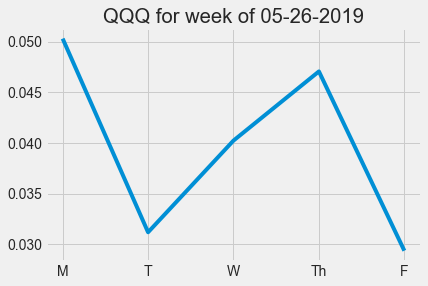

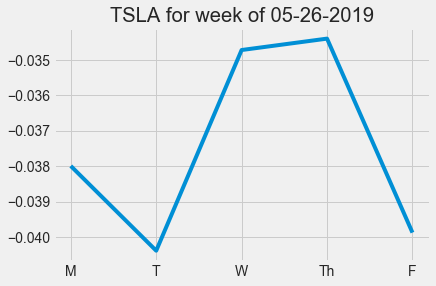

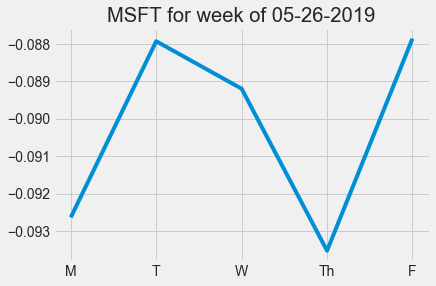

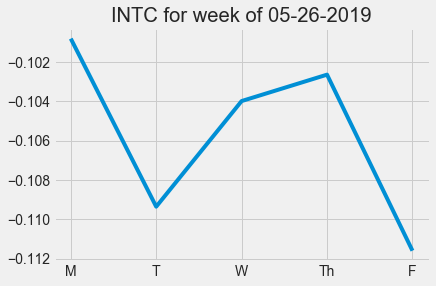

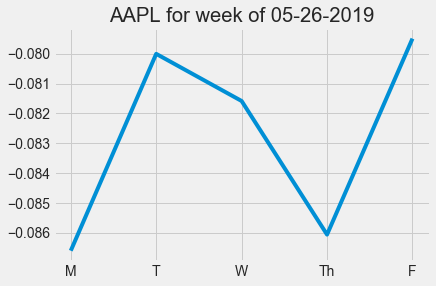

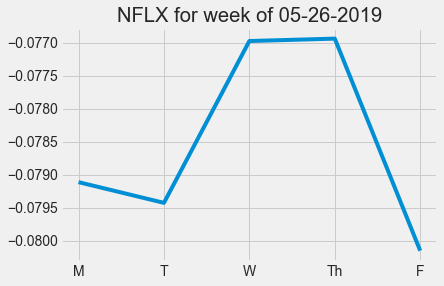

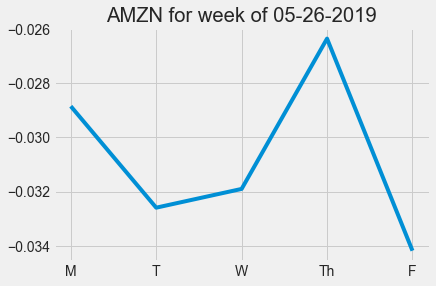

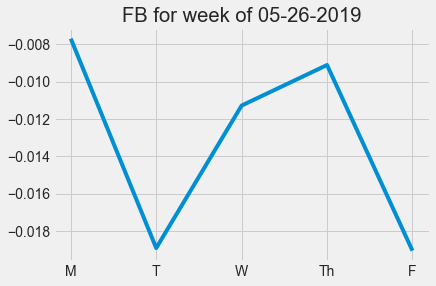

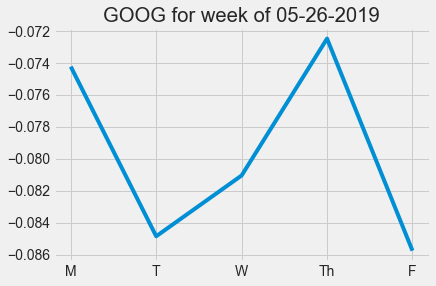

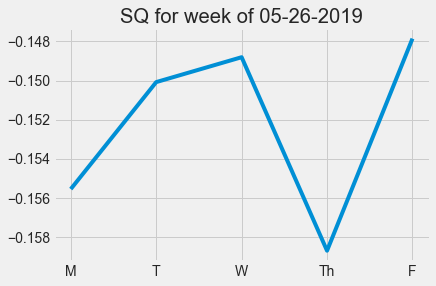

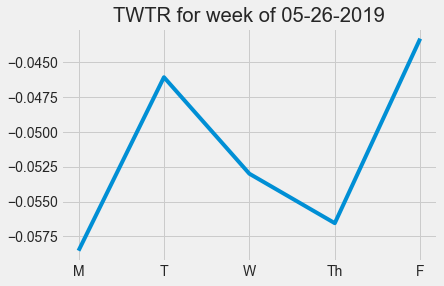

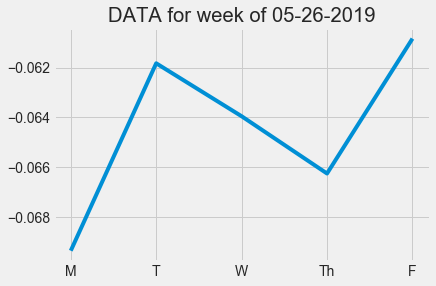

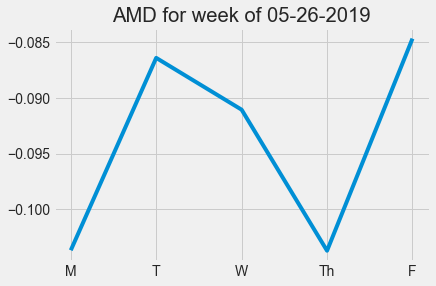

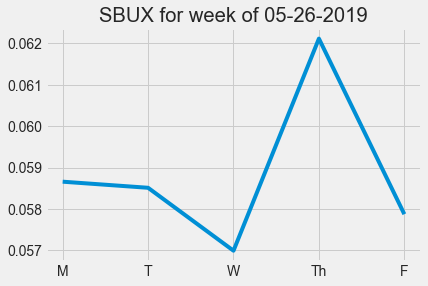

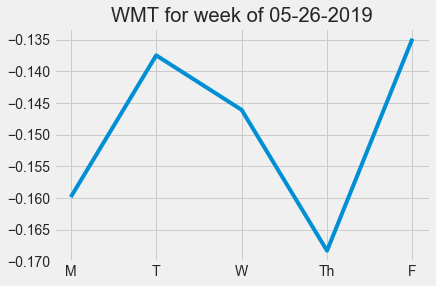

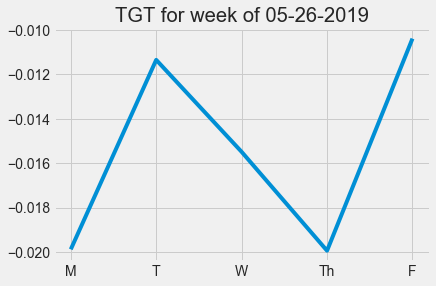

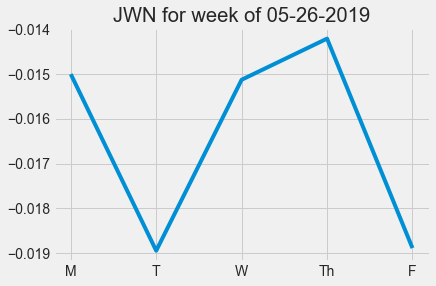

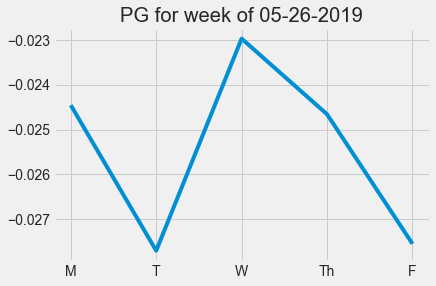

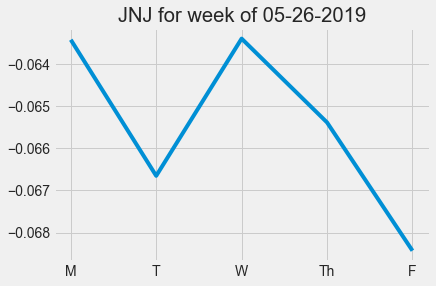

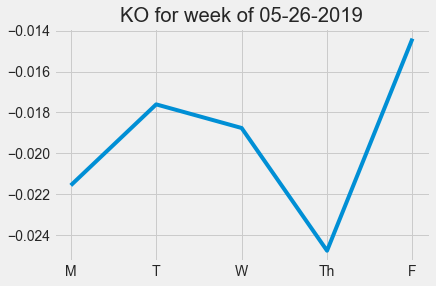

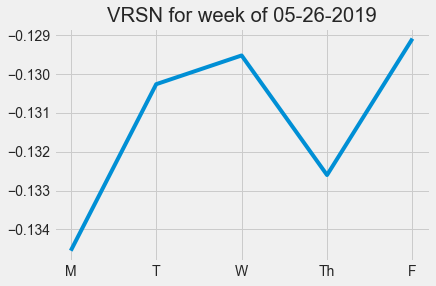

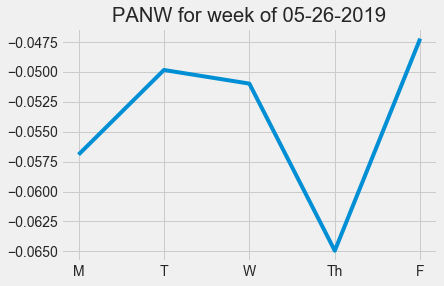

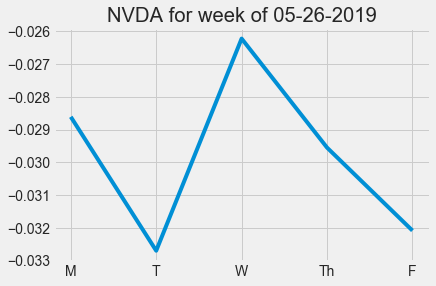

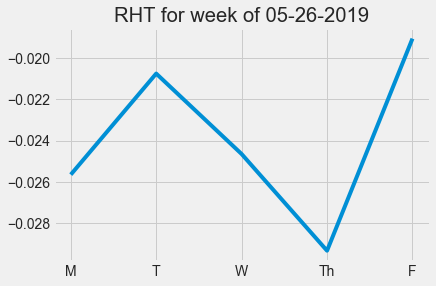

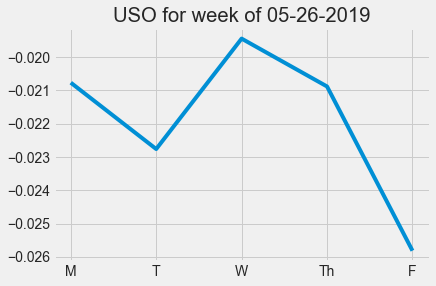

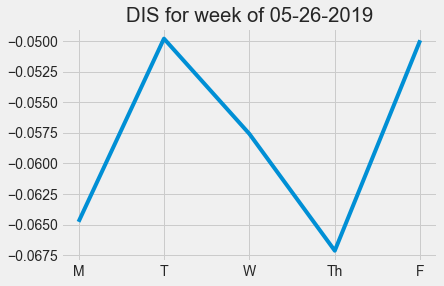

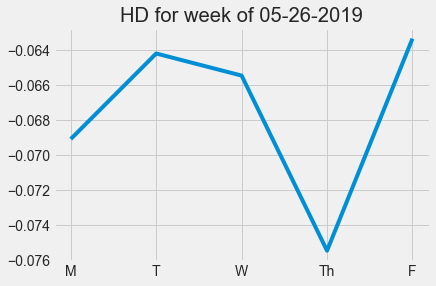

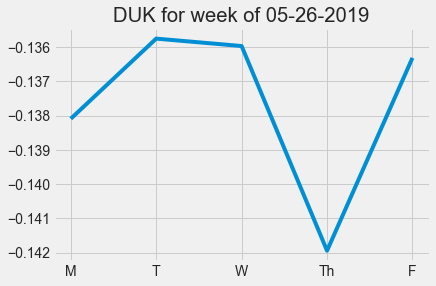

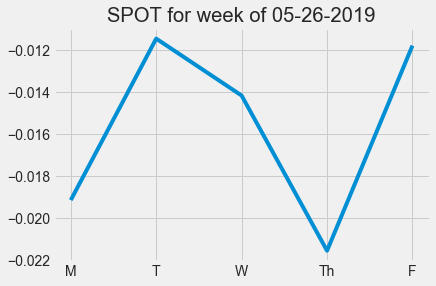

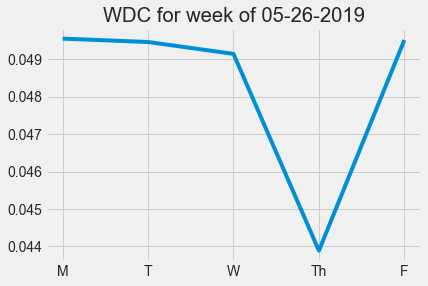

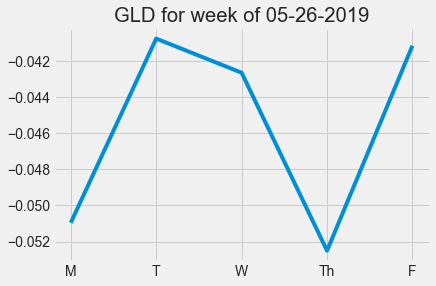

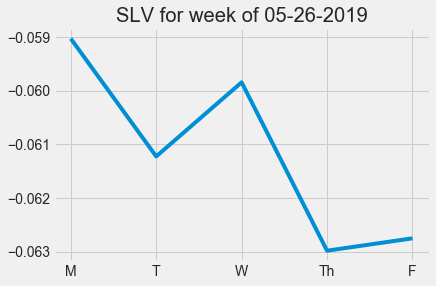

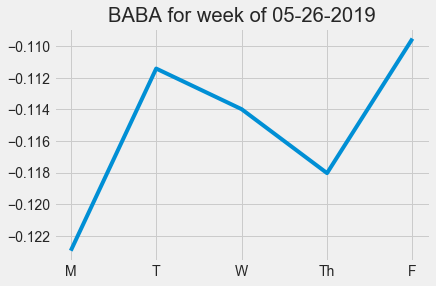

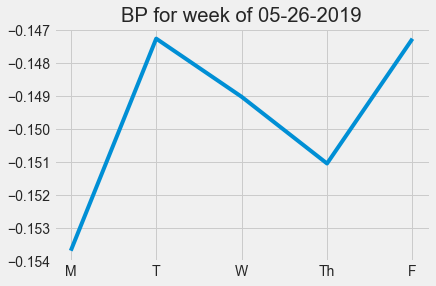

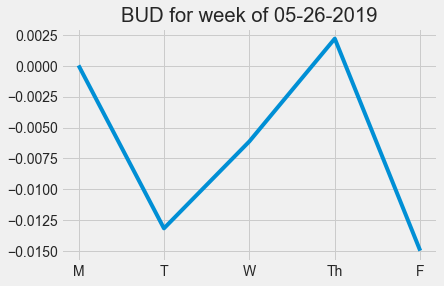

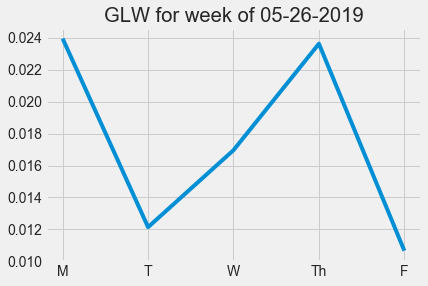

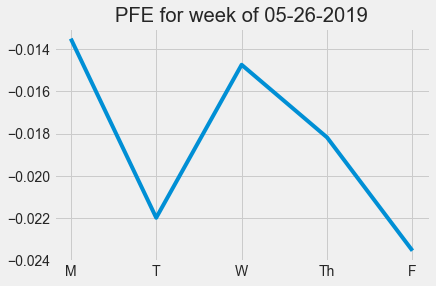

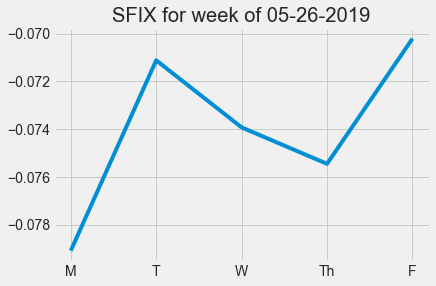

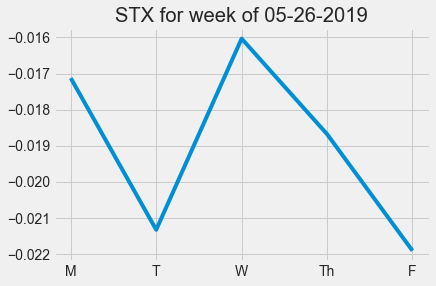

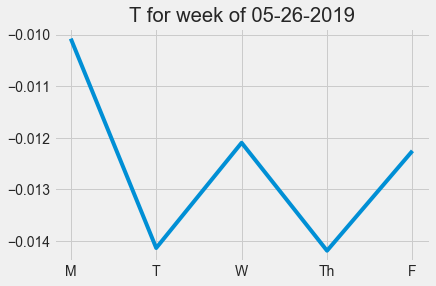

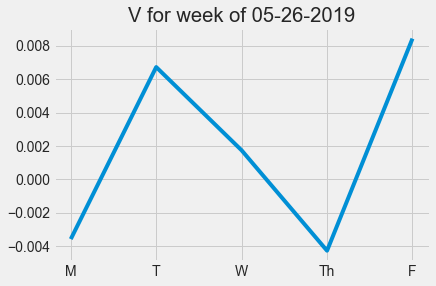

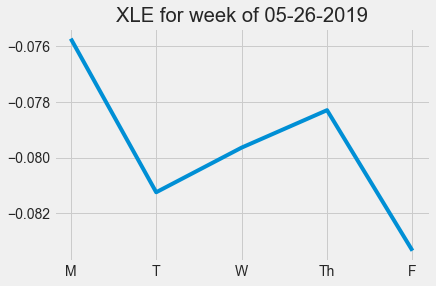

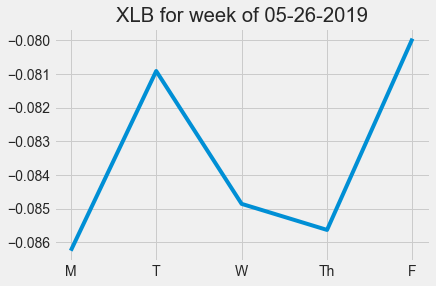

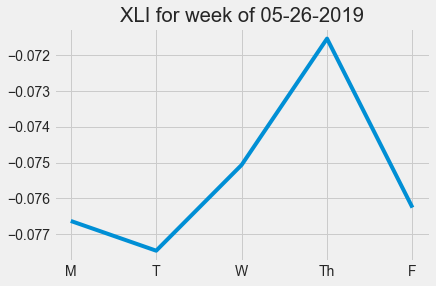

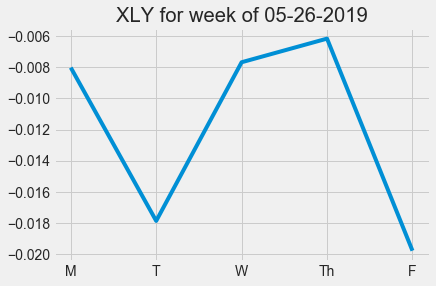

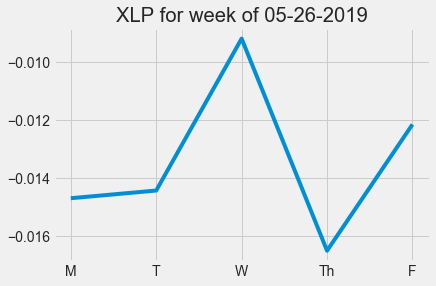

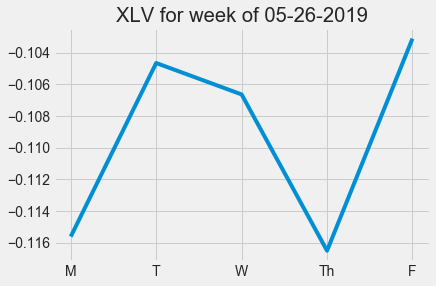

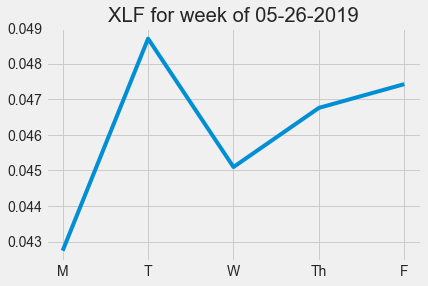

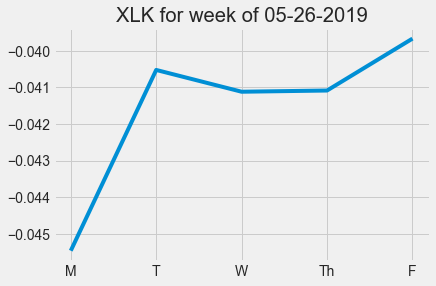

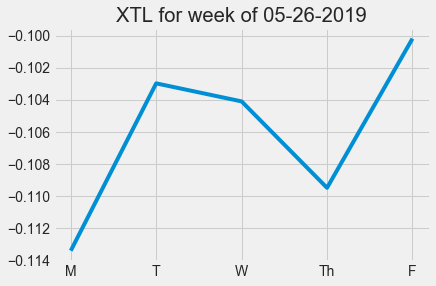

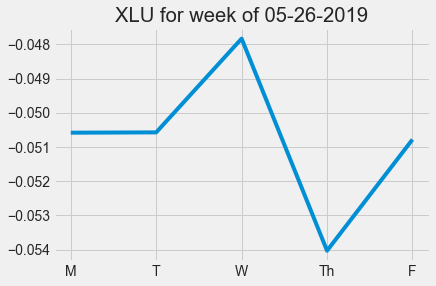

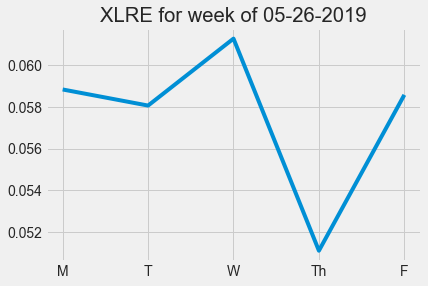

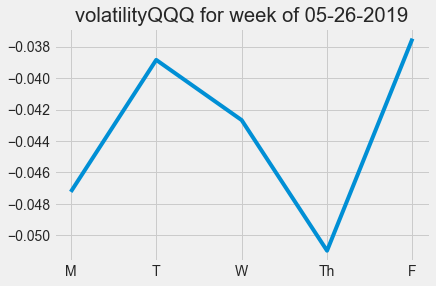

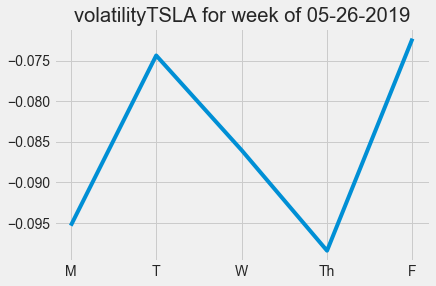

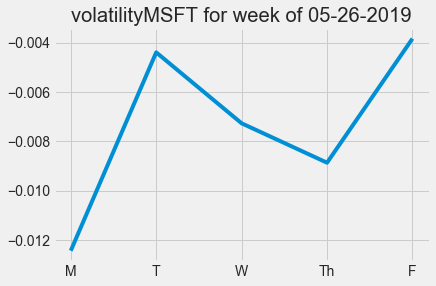

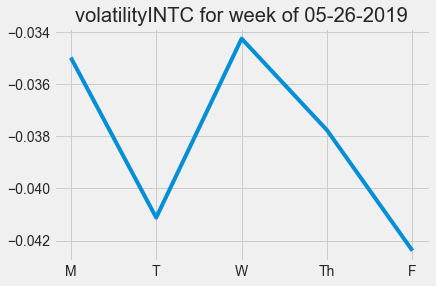

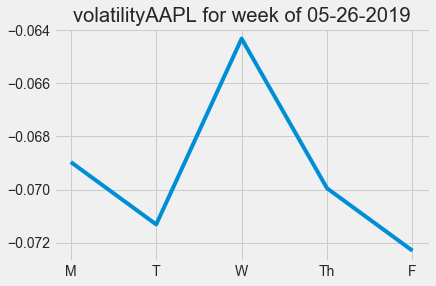

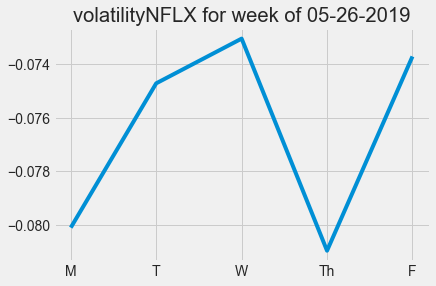

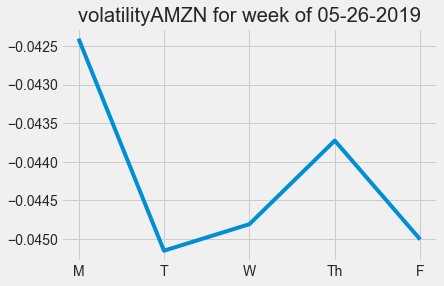

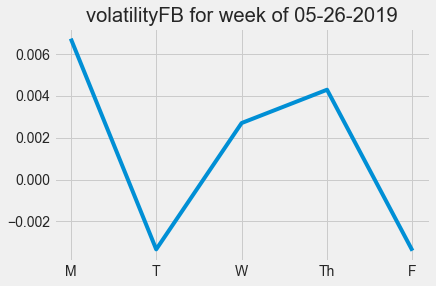

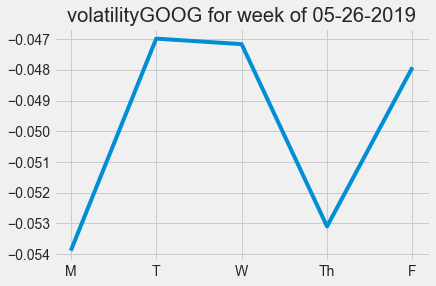

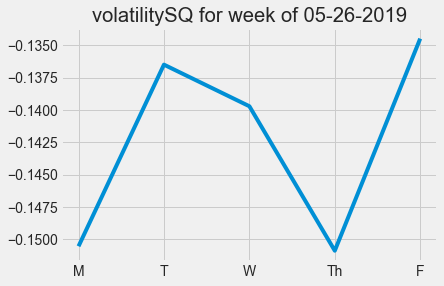

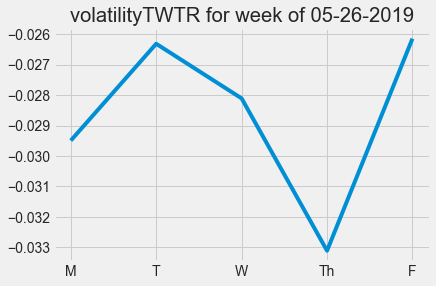

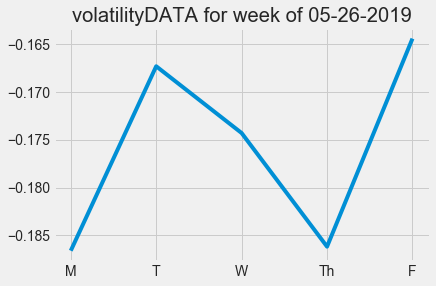

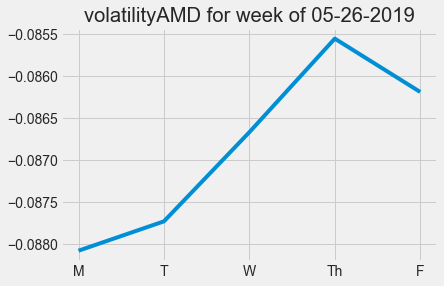

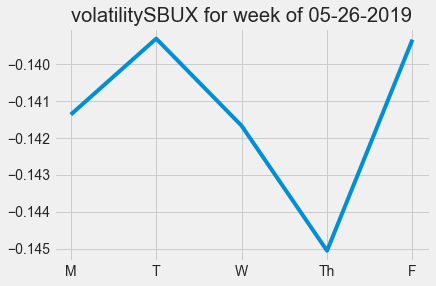

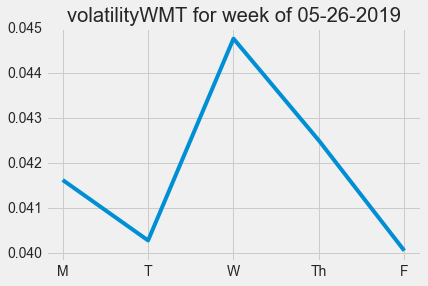

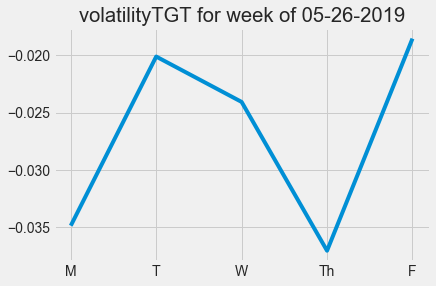

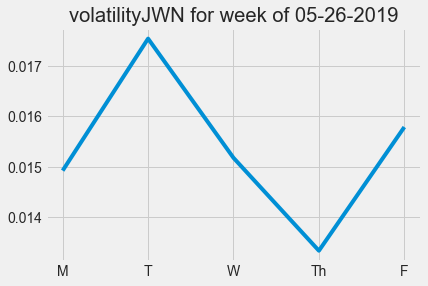

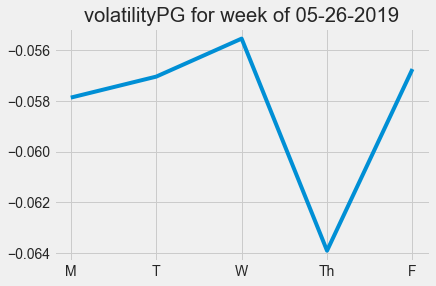

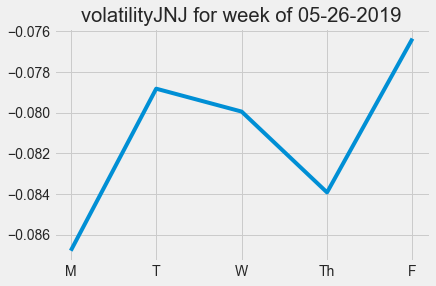

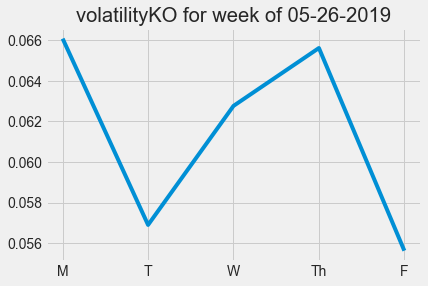

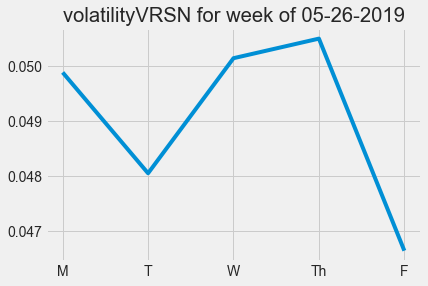

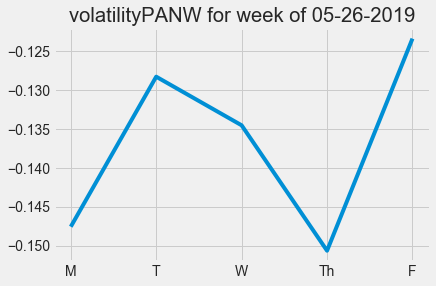

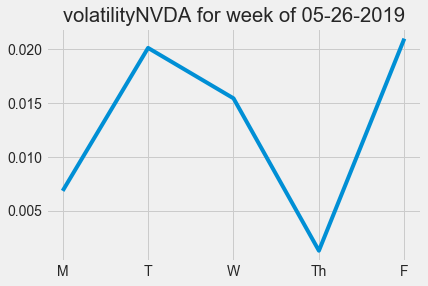

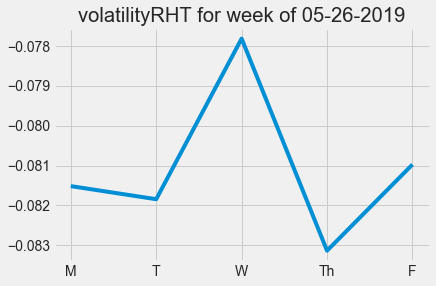

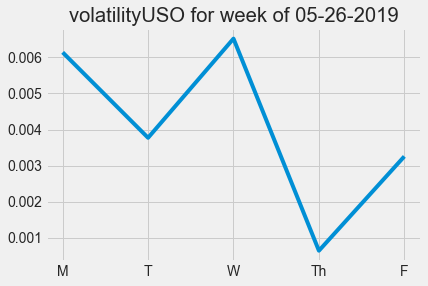

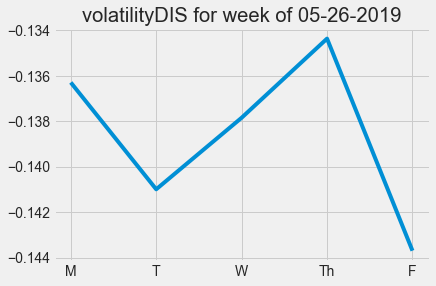

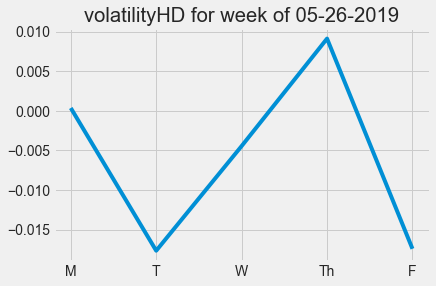

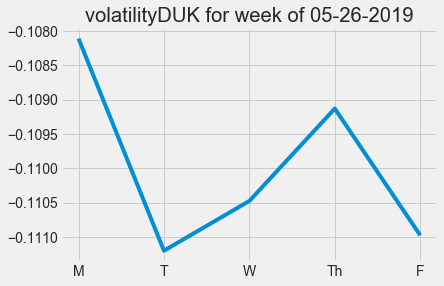

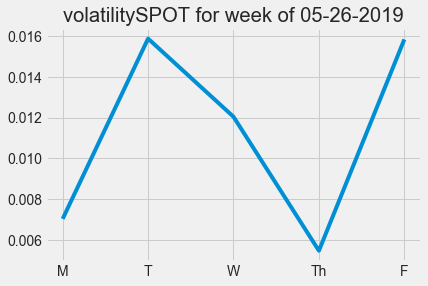

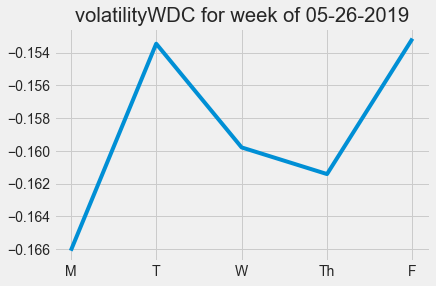

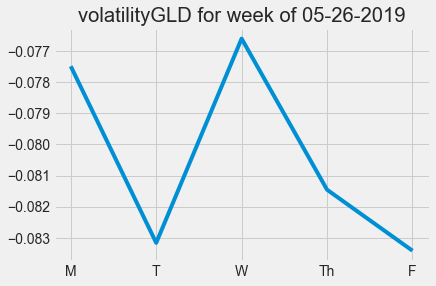

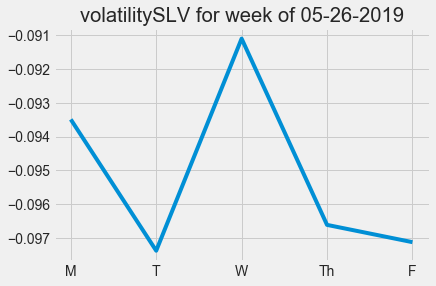

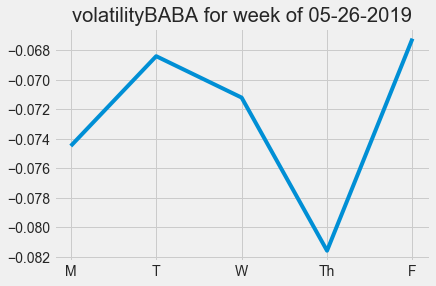

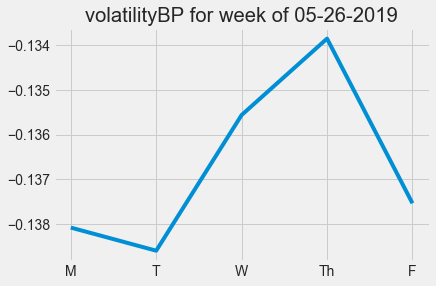

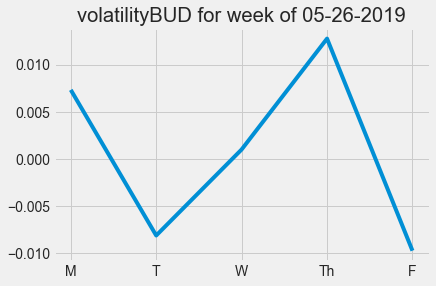

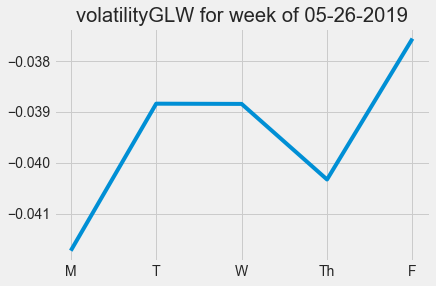

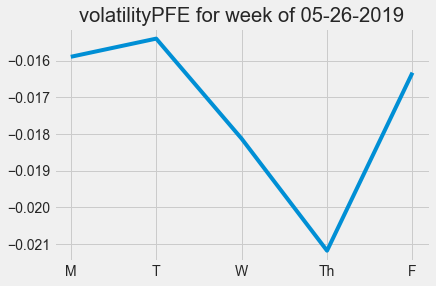

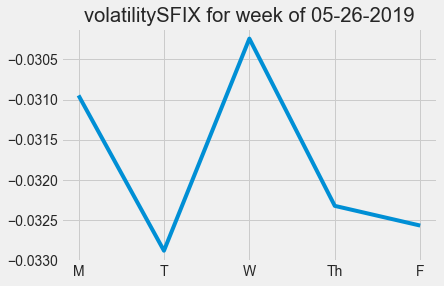

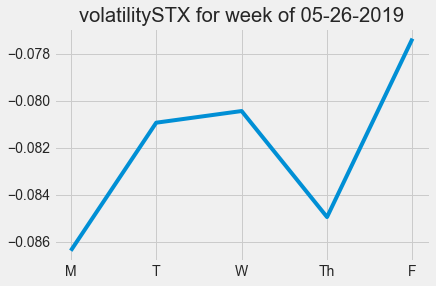

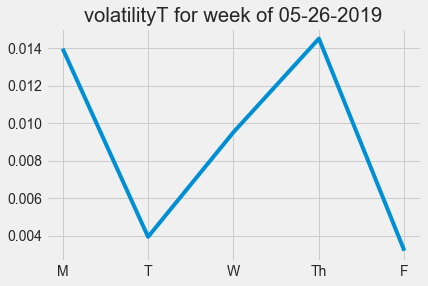

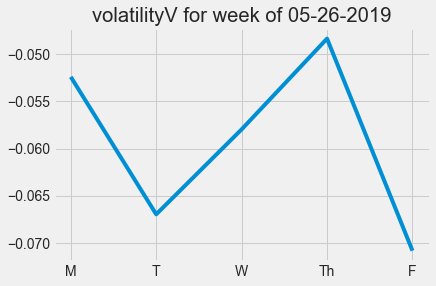

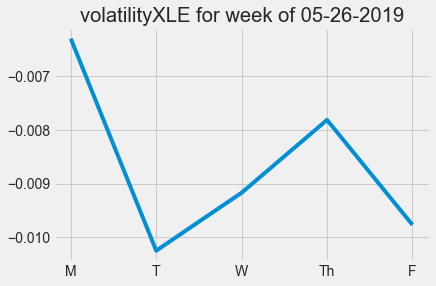

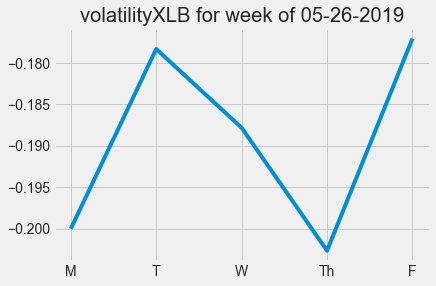

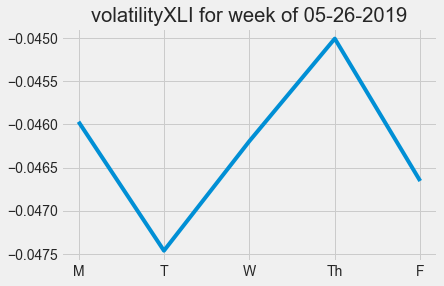

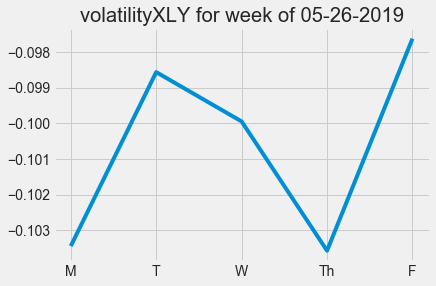

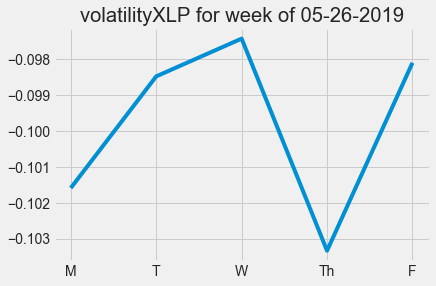

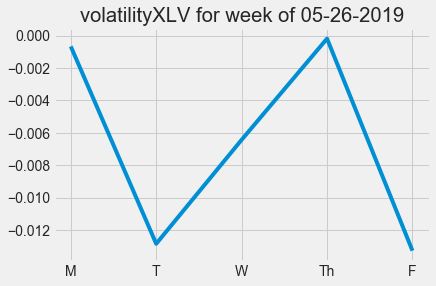

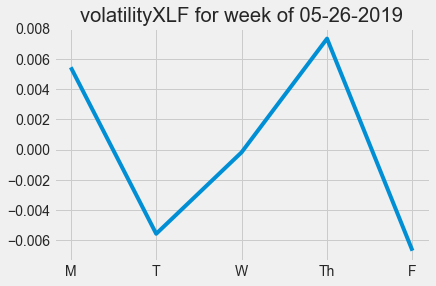

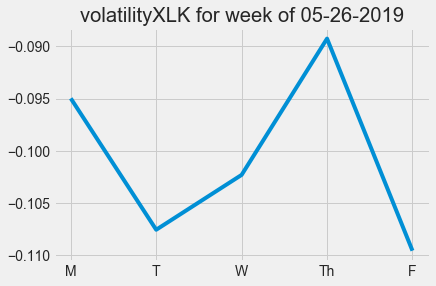

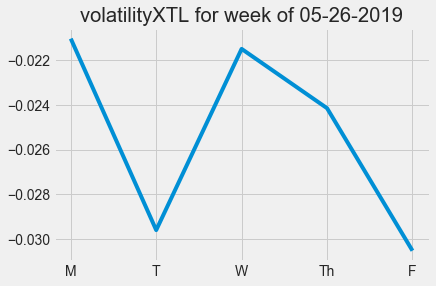

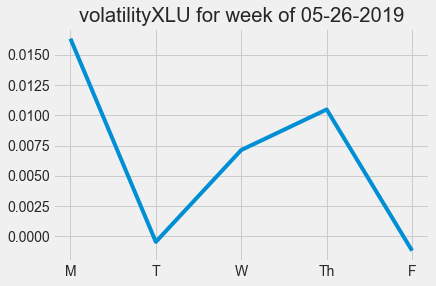

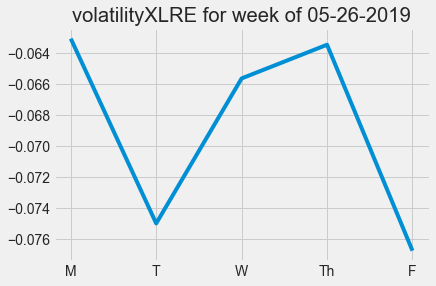

In [320]:
for t in list(ticker_lookup.keys()):
    plt.style.use('fivethirtyeight')
    plt.title(str(t)+" for week of "+str(now.month)+"-"+str(now.day)+"-"+str(now.year))
    plt.plot([i[ticker_lookup[t]] for i in best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))])
    plt.xticks(np.arange(5), ('M', 'T', 'W', 'Th', 'F'))
    if "volatility" in t:
        plt.savefig('../reports/'+t.split("volatility")[1]+'_volatility_prediction.png')
    else:
        plt.savefig('../reports/'+t+'_prediction.png')
    plt.show()

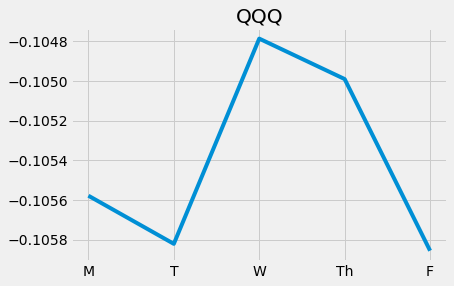

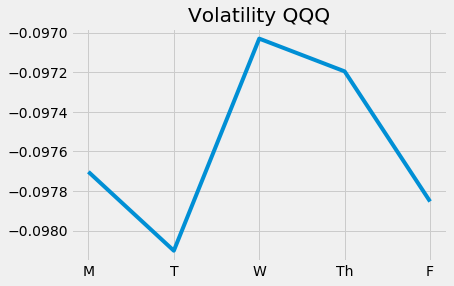

In [91]:
t = "QQQ"
plt.style.use('fivethirtyeight')
plt.title(t)
plt.plot([i[ticker_lookup[t]] for i in best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))])
plt.xticks(np.arange(5), ('M', 'T', 'W', 'Th', 'F'))
plt.show()

plt.title("Volatility "+t)
plt.plot([i[ticker_lookup["volatility"+t]] for i in best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))])
plt.xticks(np.arange(5), ('M', 'T', 'W', 'Th', 'F'))
plt.show()

In [311]:
f = open("instructions.txt", "w")
day_lookup = dict(enumerate(["M", "T", "W", "Th", "F"]))
strategy = {}
strategy["LONG"] = {"BUY" : {"M":{}, "T":{}, "W":{}, "Th":{}, "F":{}}, "SELL": {"M":{}, "T":{}, "W":{}, "Th":{}, "F":{}}}
strategy["SHORT"] = {"BUY" : {"M":{}, "T":{}, "W":{}, "Th":{}, "F":{}}, "SELL": {"M":{}, "T":{}, "W":{}, "Th":{}, "F":{}}}
tu = []
for t in list(ticker_lookup.keys()):
    week = [i[ticker_lookup[t]] for i in best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))]
    week_min = min(week)
    week_max = max(week)
    max_index = [i for i, v in enumerate(week) if v == week_max][0]
    min_index = [i for i, v in enumerate(week) if v == week_min][0]
    if min_index > max_index:
        print("LONG", t, "BUY ON", day_lookup[max_index], "SELL ON", day_lookup[min_index])
        f.write("LONG "+str(t)+" BUY ON "+str(day_lookup[max_index])+" SELL ON "+str(day_lookup[min_index])+'\n')
        strategy["LONG"]["BUY"][day_lookup[max_index]][t] = {"SELL" : day_lookup[min_index]}
        tu.append((0, t, max_index, min_index))
    else:
        print("SHORT", t, "SELL ON", day_lookup[min_index], "BUY ON", day_lookup[max_index])
        f.write("SHORT "+str(t)+" SELL ON "+str(day_lookup[min_index])+" BUY ON "+str(day_lookup[max_index])+'\n')
        strategy["SHORT"]["SELL"][day_lookup[min_index]][t] = {"BUY" : day_lookup[max_index]}
        tu.append((1, t, max_index, min_index))
        
f.close()

LONG QQQ BUY ON M SELL ON F
SHORT TSLA SELL ON T BUY ON Th
SHORT MSFT SELL ON Th BUY ON F
LONG INTC BUY ON M SELL ON F
SHORT AAPL SELL ON M BUY ON F
LONG NFLX BUY ON Th SELL ON F
LONG AMZN BUY ON Th SELL ON F
LONG FB BUY ON M SELL ON F
LONG GOOG BUY ON Th SELL ON F
SHORT SQ SELL ON Th BUY ON F
SHORT TWTR SELL ON M BUY ON F
SHORT DATA SELL ON M BUY ON F
SHORT AMD SELL ON Th BUY ON F
SHORT SBUX SELL ON W BUY ON Th
SHORT WMT SELL ON Th BUY ON F
SHORT TGT SELL ON Th BUY ON F
SHORT JWN SELL ON T BUY ON Th
SHORT PG SELL ON T BUY ON W
LONG JNJ BUY ON W SELL ON F
SHORT KO SELL ON Th BUY ON F
SHORT VRSN SELL ON M BUY ON F
SHORT PANW SELL ON Th BUY ON F
SHORT NVDA SELL ON T BUY ON W
SHORT RHT SELL ON Th BUY ON F
LONG USO BUY ON W SELL ON F
LONG DIS BUY ON T SELL ON Th
SHORT HD SELL ON Th BUY ON F
LONG DUK BUY ON T SELL ON Th
LONG SPOT BUY ON T SELL ON Th
LONG WDC BUY ON M SELL ON Th
LONG GLD BUY ON T SELL ON Th
LONG SLV BUY ON M SELL ON Th
SHORT BABA SELL ON M BUY ON F
SHORT BP SELL ON M BUY ON 

In [234]:
sorted(tu)

[(0, 'SBUX', 0, 3),
 (0, 'XLF', 2, 3),
 (0, 'XLI', 0, 2),
 (0, 'volatilityBUD', 0, 3),
 (0, 'volatilityGLW', 0, 3),
 (0, 'volatilityHD', 0, 2),
 (0, 'volatilityMSFT', 0, 3),
 (0, 'volatilityT', 1, 3),
 (0, 'volatilityV', 1, 3),
 (0, 'volatilityVRSN', 2, 3),
 (0, 'volatilityXLE', 0, 2),
 (0, 'volatilityXLK', 1, 3),
 (1, 'AAPL', 3, 0),
 (1, 'AMD', 2, 0),
 (1, 'AMZN', 1, 0),
 (1, 'BABA', 3, 0),
 (1, 'BP', 1, 0),
 (1, 'BUD', 4, 3),
 (1, 'DATA', 4, 1),
 (1, 'DIS', 3, 0),
 (1, 'DUK', 2, 0),
 (1, 'FB', 4, 0),
 (1, 'GLD', 2, 0),
 (1, 'GLW', 1, 0),
 (1, 'GOOG', 4, 0),
 (1, 'HD', 2, 0),
 (1, 'INTC', 2, 0),
 (1, 'JNJ', 2, 0),
 (1, 'JWN', 1, 0),
 (1, 'KO', 3, 0),
 (1, 'MSFT', 1, 0),
 (1, 'NFLX', 1, 0),
 (1, 'NVDA', 4, 0),
 (1, 'PANW', 3, 0),
 (1, 'PFE', 2, 0),
 (1, 'PG', 4, 0),
 (1, 'QQQ', 4, 3),
 (1, 'RHT', 3, 0),
 (1, 'SFIX', 3, 1),
 (1, 'SLV', 2, 0),
 (1, 'SPOT', 2, 0),
 (1, 'SQ', 3, 0),
 (1, 'STX', 4, 0),
 (1, 'T', 2, 0),
 (1, 'TGT', 2, 0),
 (1, 'TSLA', 4, 1),
 (1, 'TWTR', 3, 0),
 (1, 'USO', 2